# Model Evaluation

This notebook loads trained models from Modeling, reconstructs the test set, applies saved thresholds, and generates evaluation metrics & plots:

- Accuracy, Precision, Recall, F1, ROC-AUC
- ROC curve & Precision–Recall curve
- Confusion Matrix
- Comparison bar chart


## 1) Imports

In [ ]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, confusion_matrix, classification_report
)
import joblib

%matplotlib inline
print("Imports OK")


Imports OK


## 2) Load artifacts

In [ ]:
clean_path = Path("/content/clean_weather.csv")
idx_path = Path("/content/test_indices.csv")
ytest_path = Path("/content/y_test.csv")

# thresholds (optional)
thresholds = {}
for fn in ["thresholds_intermediate.json", "thresholds.json"]:
    p = Path(fn)
    if p.exists():
        thresholds.update(json.loads(p.read_text(encoding="utf-8")))

df = pd.read_csv(clean_path, parse_dates=["Date"])
test_idx = pd.read_csv(idx_path)["index"].values
y_test = pd.read_csv(ytest_path).iloc[:,0].values

X = df.drop(columns=["RainTomorrow"])
X_test = X.iloc[test_idx]

print("X_test:", X_test.shape, "y_test:", len(y_test))
print("Loaded thresholds for:", list(thresholds.keys()))


X_test: (28439, 29) y_test: 28439
Loaded thresholds for: []


## 3) Load models found

In [ ]:
import os
print(os.getcwd())
print(os.listdir())

/content
['.config', 'model_xgb_intermediate.pkl', '.ipynb_checkpoints', 'metrics_models_intermediate.csv', 'model_logreg.pkl', 'test_indices.csv', 'model_rf.pkl', 'thresholds_intermediate.json', 'y_test.csv', 'clean_weather.csv', 'model_logreg_intermediate.pkl', 'model_rf_intermediate.pkl', 'sample_data']


In [ ]:
models = {}

candidates = {
    "LogisticRegression": ["/content/model_logreg.pkl"],
    "RandomForest": ["/content/model_rf.pkl"],
    "XGBoost": ["/content/model_xgb_intermediate.pkl"],
}

for name, files in candidates.items():
    for fname in files:
        p = Path(fname)
        if p.exists():
            models[name] = joblib.load(p)
            print(f"Loaded {name} from {fname}")
            break

print("Models loaded:", list(models.keys()))


Loaded LogisticRegression from /content/model_logreg.pkl
Loaded RandomForest from /content/model_rf.pkl
Loaded XGBoost from /content/model_xgb_intermediate.pkl
Models loaded: ['LogisticRegression', 'RandomForest', 'XGBoost']


## 4) Helpers

In [ ]:
def eval_model(name, model, X_test, y_test, threshold=None):
    proba = model.predict_proba(X_test)[:,1]
    if threshold is None:
        prec, rec, thr = precision_recall_curve(y_test, proba)
        f1_vals = 2 * (prec * rec) / (prec + rec + 1e-12)
        i = int(np.nanargmax(f1_vals))
        threshold = float(thr[i]) if i < len(thr) else 0.5
    pred = (proba >= threshold).astype(int)
    m = {
        "model": name,
        "threshold": threshold,
        "roc_auc": roc_auc_score(y_test, proba),
        "accuracy": accuracy_score(y_test, pred),
        "precision": precision_score(y_test, pred),
        "recall": recall_score(y_test, pred),
        "f1": f1_score(y_test, pred)
    }
    return proba, pred, m

In [ ]:
def plot_curves(name, y_test, proba):
    fpr, tpr, _ = roc_curve(y_test, proba)
    prec, rec, _ = precision_recall_curve(y_test, proba)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=name)
    plt.plot([0,1],[0,1],"--")
    plt.title(f"ROC Curve — {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(rec, prec, label=name)
    plt.title(f"Precision–Recall Curve — {name}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.tight_layout(); plt.show()

In [ ]:
def plot_confusion(name, y_test, pred):
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xticks([0,1], ["Pred 0","Pred 1"]); plt.yticks([0,1], ["True 0","True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha="center", va="center")
    plt.tight_layout(); plt.show()

## 5) Evaluate and plot


===  LogisticRegression  ===
model        LogisticRegression
threshold              0.600356
roc_auc                0.874465
accuracy               0.828827
precision              0.602671
recall                 0.693804
f1                     0.645034
dtype: object


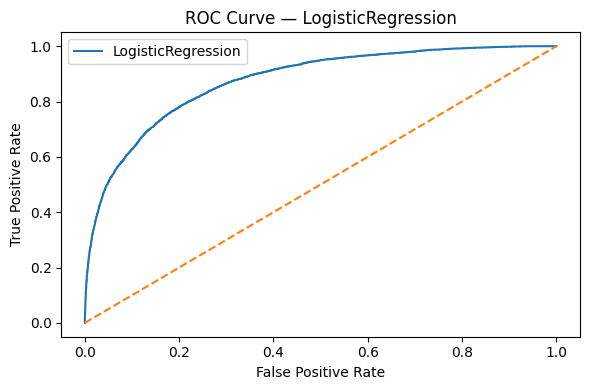

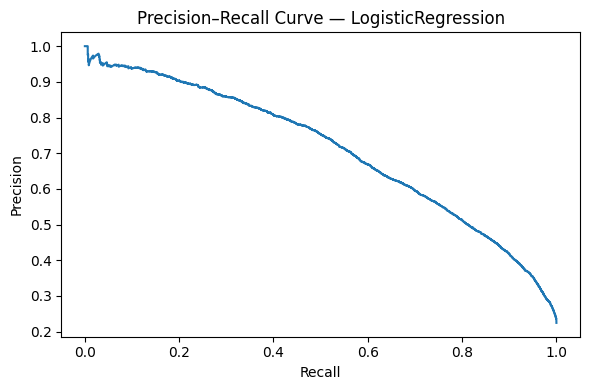

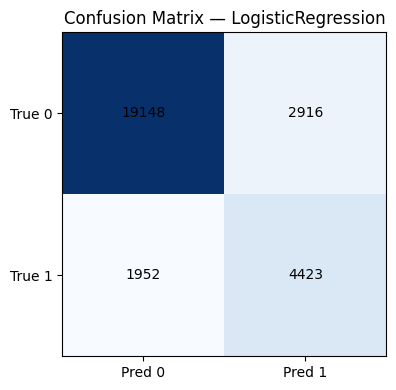


===  RandomForest  ===
model        RandomForest
threshold        0.324867
roc_auc          0.882957
accuracy         0.843841
precision        0.645108
recall           0.674353
f1               0.659406
dtype: object


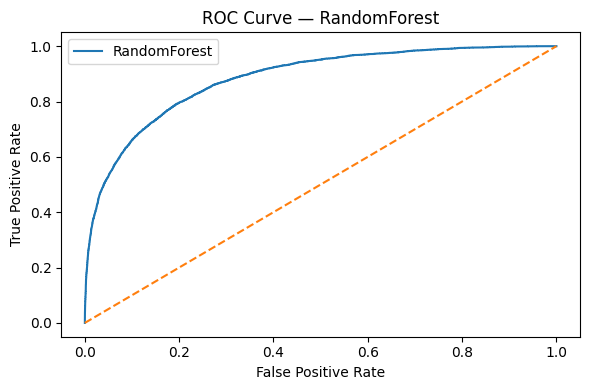

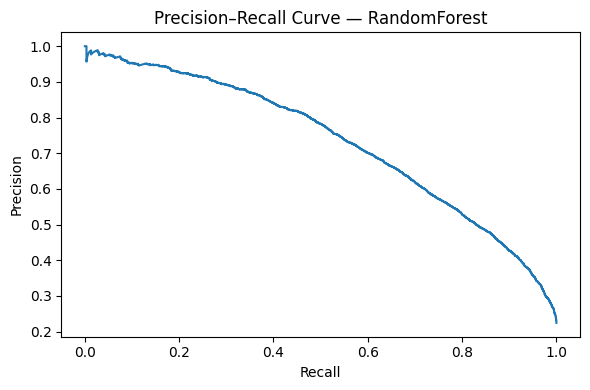

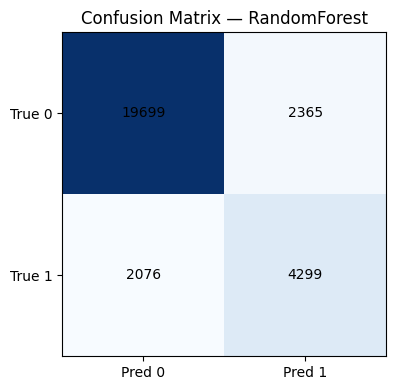


===  XGBoost  ===
model         XGBoost
threshold    0.311954
roc_auc      0.897626
accuracy     0.847322
precision     0.64323
recall       0.716078
f1           0.677702
dtype: object


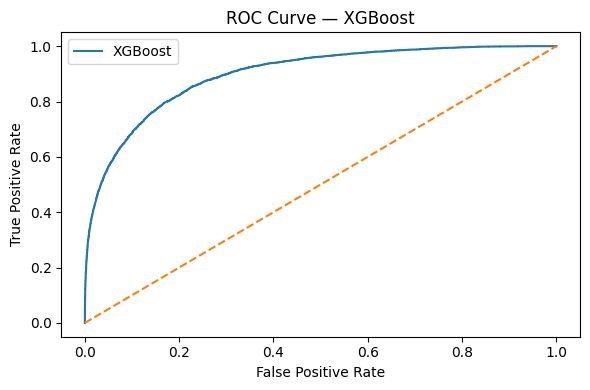

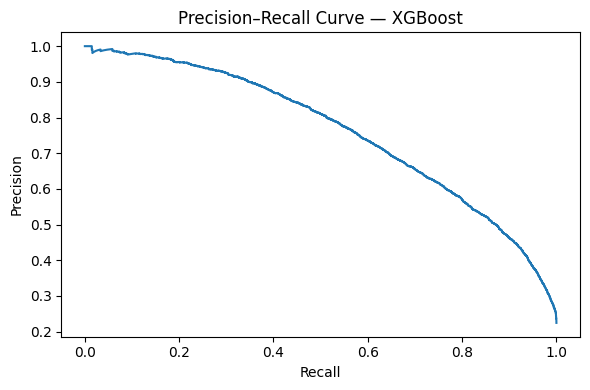

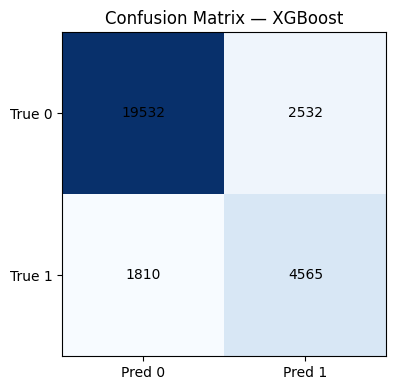

,model,threshold,roc_auc,accuracy,precision,recall,f1
2,XGBoost,0.311954,0.897626,0.847322,0.643230,0.716078,0.677702
1,RandomForest,0.324867,0.882957,0.843841,0.645108,0.674353,0.659406
0,LogisticRegression,0.600356,0.874465,0.828827,0.602671,0.693804,0.645034


In [ ]:
metrics = []
for name, model in models.items():
    thr = thresholds.get(name)
    alias = {"LogisticRegression":"LogisticRegression_fixed",
             "RandomForest":"RandomForest_fixed",
             "XGBoost":"XGBoost_fixed"}
    if thr is None and name in alias:
        thr = thresholds.get(alias[name])

    proba, pred, m = eval_model(name, model, X_test, y_test, threshold=thr)
    metrics.append(m)

    print("\n=== ", name, " ===")
    print(pd.Series(m))

    plot_curves(name, y_test, proba)
    plot_confusion(name, y_test, pred)

metrics_df = pd.DataFrame(metrics).sort_values("roc_auc", ascending=False)
metrics_df

## 6) Comparison chart & save table

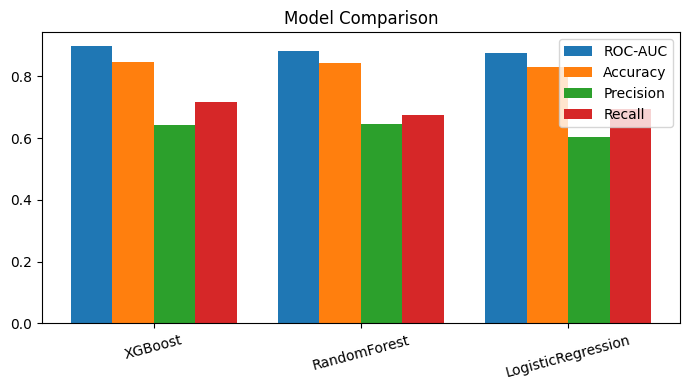

Saved /content/metrics_models_evaluated.csv


,model,threshold,roc_auc,accuracy,precision,recall,f1
2,XGBoost,0.311954,0.897626,0.847322,0.643230,0.716078,0.677702
1,RandomForest,0.324867,0.882957,0.843841,0.645108,0.674353,0.659406
0,LogisticRegression,0.600356,0.874465,0.828827,0.602671,0.693804,0.645034


In [ ]:
plt.figure(figsize=(7,4))
x = np.arange(len(metrics_df))
plt.bar(x - 0.3, metrics_df["roc_auc"], width=0.2, label="ROC-AUC")
plt.bar(x - 0.1, metrics_df["accuracy"], width=0.2, label="Accuracy")
plt.bar(x + 0.1, metrics_df["precision"], width=0.2, label="Precision")
plt.bar(x + 0.3, metrics_df["recall"], width=0.2, label="Recall")
plt.xticks(x, metrics_df["model"], rotation=15)
plt.title("Model Comparison"); plt.legend(); plt.tight_layout(); plt.show()

csv_out = Path("metrics_models_evaluated.csv")
metrics_df.to_csv(csv_out, index=False)
print("Saved", csv_out.resolve())
metrics_df
